In [1]:
%matplotlib inline
from StringProcessing import StringProcessing
from BuildVocabulary import BuildVocabulary as bv
from TransformerEncoder import TransformerEncoder
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from nltk.tokenize.toktok import ToktokTokenizer
from Visualization import Visualization
from gensim.models import Word2Vec
from Preprocess import Preprocess
from Utils import Utils
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

Using TensorFlow backend.


# Parameters

In [2]:
# Text parameters #
max_words = 50
test_path = "./tass-corpus/es/dev.csv"

# Training Parameters #
path_model = "./best-models/transformer_1648NO.hdf5"
r_cats = {0:"N", 1:"NEU", 2:"NONE", 3:"P"}
tokenizer = ToktokTokenizer()
w2v_path = "./twitter87/twitter87.model"
w2v = Word2Vec.load(w2v_path)

# Encoder Parameters # # MEJOR
dropout_input = 0.7 #0.7
dropout_output = 0. # 0.
pe = False #False
embedding_dims = w2v.vector_size
n_encoders = 1 #2 #1
attention_dims = 64 #32 #64
n_heads = 8 #8
dim_h = 128 #256
final_h = False #False
pool_mode = "average" #"average"

output_encoder_dims = [embedding_dims for i in range(n_encoders)]
attention_dims = [attention_dims for i in range(n_encoders)]
n_heads = [n_heads for i in range(n_encoders)]

# Prepare inputs #

In [3]:
ids_dv, x_dv, y_dv = StringProcessing.load_samples(test_path)

# Preprocess #
x_dv = [Preprocess.preprocess(x, tokenizer) for x in x_dv]

# Represent #
rx_dv = np.array(StringProcessing.represent_documents(x_dv, max_words, embedding_dims, w2v, word_delimiter = " "))

# Masks #
masks_dv = np.array([((rx!=0).sum(axis=1)>0).astype("int") for rx in rx_dv])

# Positional Encodings #
matrix_pos_encodings = Utils.precompute_sent_pos_encodings(max_words, embedding_dims)
pe_dv = np.array([Utils.build_pe_sent_encodings(matrix_pos_encodings, m) for m in masks_dv])

# Load model

In [4]:
ht = TransformerEncoder(max_words = max_words,
                 embedding_dims = embedding_dims,
                 output_encoder_dims = output_encoder_dims,
                 attention_dims = attention_dims,
                 n_heads = n_heads,
                 dropout_input = dropout_input,
                 dropout_output = dropout_output,
                 pe = pe,
                 dim_h = dim_h,
                 final_h = final_h,
                 pool_mode = pool_mode)

ht.build()
print(ht.model.summary())
ht.compile(ht.model)
ht.load(ht.model, path_model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
my_masking_1 (MyMasking)        (None, 50, 300)      0           input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 300)      0           my_masking_1[0][0]               
__________________________________________________________________________________________________
sentence_encoder_bloc

# Predict

In [5]:
preds = ht.model.predict([rx_dv, masks_dv, pe_dv], batch_size=256)
preds = [r_cats[p.argmax()] for p in preds]
truths = y_dv
print("Acc: %f" % accuracy_score(truths, preds))
print("MF1: %f" % f1_score(truths, preds, average="macro"))
print("MP: %f" % precision_score(truths, preds, average="macro"))
print("MR: %f" % recall_score(truths, preds, average="macro"))
print("Conf Matrix\n", confusion_matrix(truths, preds))
print("Classification Report\n", classification_report(truths, preds))

Acc: 0.607573
MF1: 0.533422
MP: 0.527952
MR: 0.543807
Conf Matrix
 [[195  25  18  28]
 [ 25  22  13  23]
 [  9   6  38  11]
 [ 38  19  13  98]]
Classification Report
               precision    recall  f1-score   support

           N       0.73      0.73      0.73       266
         NEU       0.31      0.27      0.28        83
        NONE       0.46      0.59      0.52        64
           P       0.61      0.58      0.60       168

   micro avg       0.61      0.61      0.61       581
   macro avg       0.53      0.54      0.53       581
weighted avg       0.61      0.61      0.61       581



# Save Prediction Report

In [6]:
# Guarda un csv (texto, real, prediccion)
fw = open("results_report.csv", "w", encoding="utf8")
for i in range(len(preds)):
    fw.write(x_dv[i] + "\t" + truths[i] + "\t" + preds[i] + "\n")
fw.close()

# Get Attention Report

In [7]:
attns = ht.attn_model.predict([rx_dv, masks_dv, pe_dv], batch_size=256)

## Preds

In [14]:
# Palabra : {cabezal : {P:0, N:0, NEU:}}
word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = preds[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}
                counters[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}

            word_attns[word][h][pred] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h][pred] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        for c in word_attns[w][h]:
            word_attns[w][h][c] /= len(x_dv)      

In [15]:
word_attns["mierda"]

{0: {'N': 0.0017153485279901358,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.0007692033267882934},
 1: {'N': 0.004626692089002594,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 2.852761909596481e-05},
 2: {'N': 6.690010907305826e-06,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 4.9410337380257e-06},
 3: {'N': 0.007457074933249687,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.0016789873372667218},
 4: {'N': 9.568202950946414e-06,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 1.4074369459517184e-07},
 5: {'N': 0.0020575475309095926,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.00041438772530646},
 6: {'N': 0.005116721987968566,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 0.0003282754279660276},
 7: {'N': 4.239669097647991e-06,
  'NEU': 0.0,
  'NONE': 0.0,
  'P': 3.6553280963442205e-06}}

## Truths

In [16]:
# Palabra : {cabezal : {P:0, N:0, NEU:}}
word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = truths[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}
                counters[word][h] = {"N":0., "NEU":0., "NONE":0., "P":0.}

            word_attns[word][h][pred] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h][pred] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        for c in word_attns[w][h]:
            word_attns[w][h][c] /= len(x_dv) 

In [17]:
word_attns["mierda"]

{0: {'N': 0.001714852879959335,
  'NEU': 0.0007692033267882934,
  'NONE': 0.0,
  'P': 4.956480308007866e-07},
 1: {'N': 0.0034390558563802812,
  'NEU': 2.852761909596481e-05,
  'NONE': 0.0,
  'P': 0.0011876362326223141},
 2: {'N': 6.69001014009853e-06,
  'NEU': 4.9410337380257e-06,
  'NONE': 0.0,
  'P': 7.672072959718464e-13},
 3: {'N': 0.0060575509798923115,
  'NEU': 0.0016789873372667218,
  'NONE': 0.0,
  'P': 0.0013995239533573748},
 4: {'N': 4.585693860091132e-06,
  'NEU': 1.4074369459517184e-07,
  'NONE': 0.0,
  'P': 4.982509090855281e-06},
 5: {'N': 0.0014617697451931007,
  'NEU': 0.00041438772530646,
  'NONE': 0.0,
  'P': 0.0005957777857164918},
 6: {'N': 0.004293711229813177,
  'NEU': 0.0003282754279660276,
  'NONE': 0.0,
  'P': 0.0008230107581553894},
 7: {'N': 4.2217952970090075e-06,
  'NEU': 3.6553280963442205e-06,
  'NONE': 0.0,
  'P': 1.7873800638982972e-08}}

## All classes

In [18]:
# Palabra : {cabezal : }

word_attns = {}
counters = {}
for i in range(len(x_dv)):
    attns_i = attns[i]
    pred = truths[i]
    l_words = x_dv[i].split()
    pad = 0
    
    while len(l_words) < max_words:
        l_words.insert(0, "<pad>")
        pad += 1
    l_words = l_words[pad:]
    attns_i = attns_i[:, pad:, pad:]
    attns_i = attns_i.sum(axis=1)          
    ll_words = len(l_words)
    
    for j in range(ll_words):
        word = l_words[j]
        if word not in word_attns:
            word_attns[word] = {}
            counters[word] = {}
            
        for h in range(len(attns_i)):
            if h not in word_attns[word]:
                word_attns[word][h] = 0.
                counters[word][h] = 0.

            word_attns[word][h] += (attns_i[h][j] / ll_words) # Normalizar por el nº de palabras a las que atiende
            counters[word][h] += 1.

# Normalizar por el nº de muestras
for w in word_attns:
    for h in word_attns[w]:
        word_attns[w][h] /= len(x_dv) 

In [19]:
word_attns["mierda"]

{0: 0.0024845518547784292,
 1: 0.004655219708098559,
 2: 1.1631044645331525e-05,
 3: 0.009136062270516408,
 4: 9.708946645541585e-06,
 5: 0.0024719352562160525,
 6: 0.005444997415934593,
 7: 7.894997193992212e-06}

In [21]:
word_attns["genial"]

{0: 2.649026724098605e-05,
 1: 0.006200643151232649,
 2: 0.007157445468843605,
 3: 0.0008024270140503219,
 4: 0.01357130495113112,
 5: 0.0006907809286857419,
 6: 3.19597419752231e-05,
 7: 6.250333000592587e-07}

In [22]:
word_attns["horrible"]

{0: 2.5105159312948302e-05,
 1: 0.001257633998759232,
 2: 1.771617744906634e-05,
 3: 0.0017140776483204198,
 4: 9.779741093131639e-05,
 5: 0.0007750016994607633,
 6: 0.00041638999510550047,
 7: 5.746135554675545e-08}

In [23]:
word_attns["maravilloso"]

{0: 3.8982627898260033e-08,
 1: 0.002564629000830206,
 2: 0.003236620348463652,
 3: 0.0006010709237014243,
 4: 0.004990253500326967,
 5: 0.0018389675268026,
 6: 5.787014189066984e-07,
 7: 0.00015825514362931983}

# Attns Visualization

In [48]:
n = 17
attns_i = attns[n]
l_words = ["feliz", "jodido", "vida", "muerte", "genial", "maravilloso", "horrible"] #x_dv[n].split()

pad = 0
while len(l_words) < max_words:
    l_words.insert(0, "<pad>")
    pad += 1
    
l_words = l_words[pad:]
attns_i = attns_i[:, pad:, pad:]
attns_h_4 = attns_i[4]
attns_h_6 = attns_i[6]

In [49]:
print(x_dv[n])

user tu siempre sexy nerea que tengas un maravilloso dia besitos


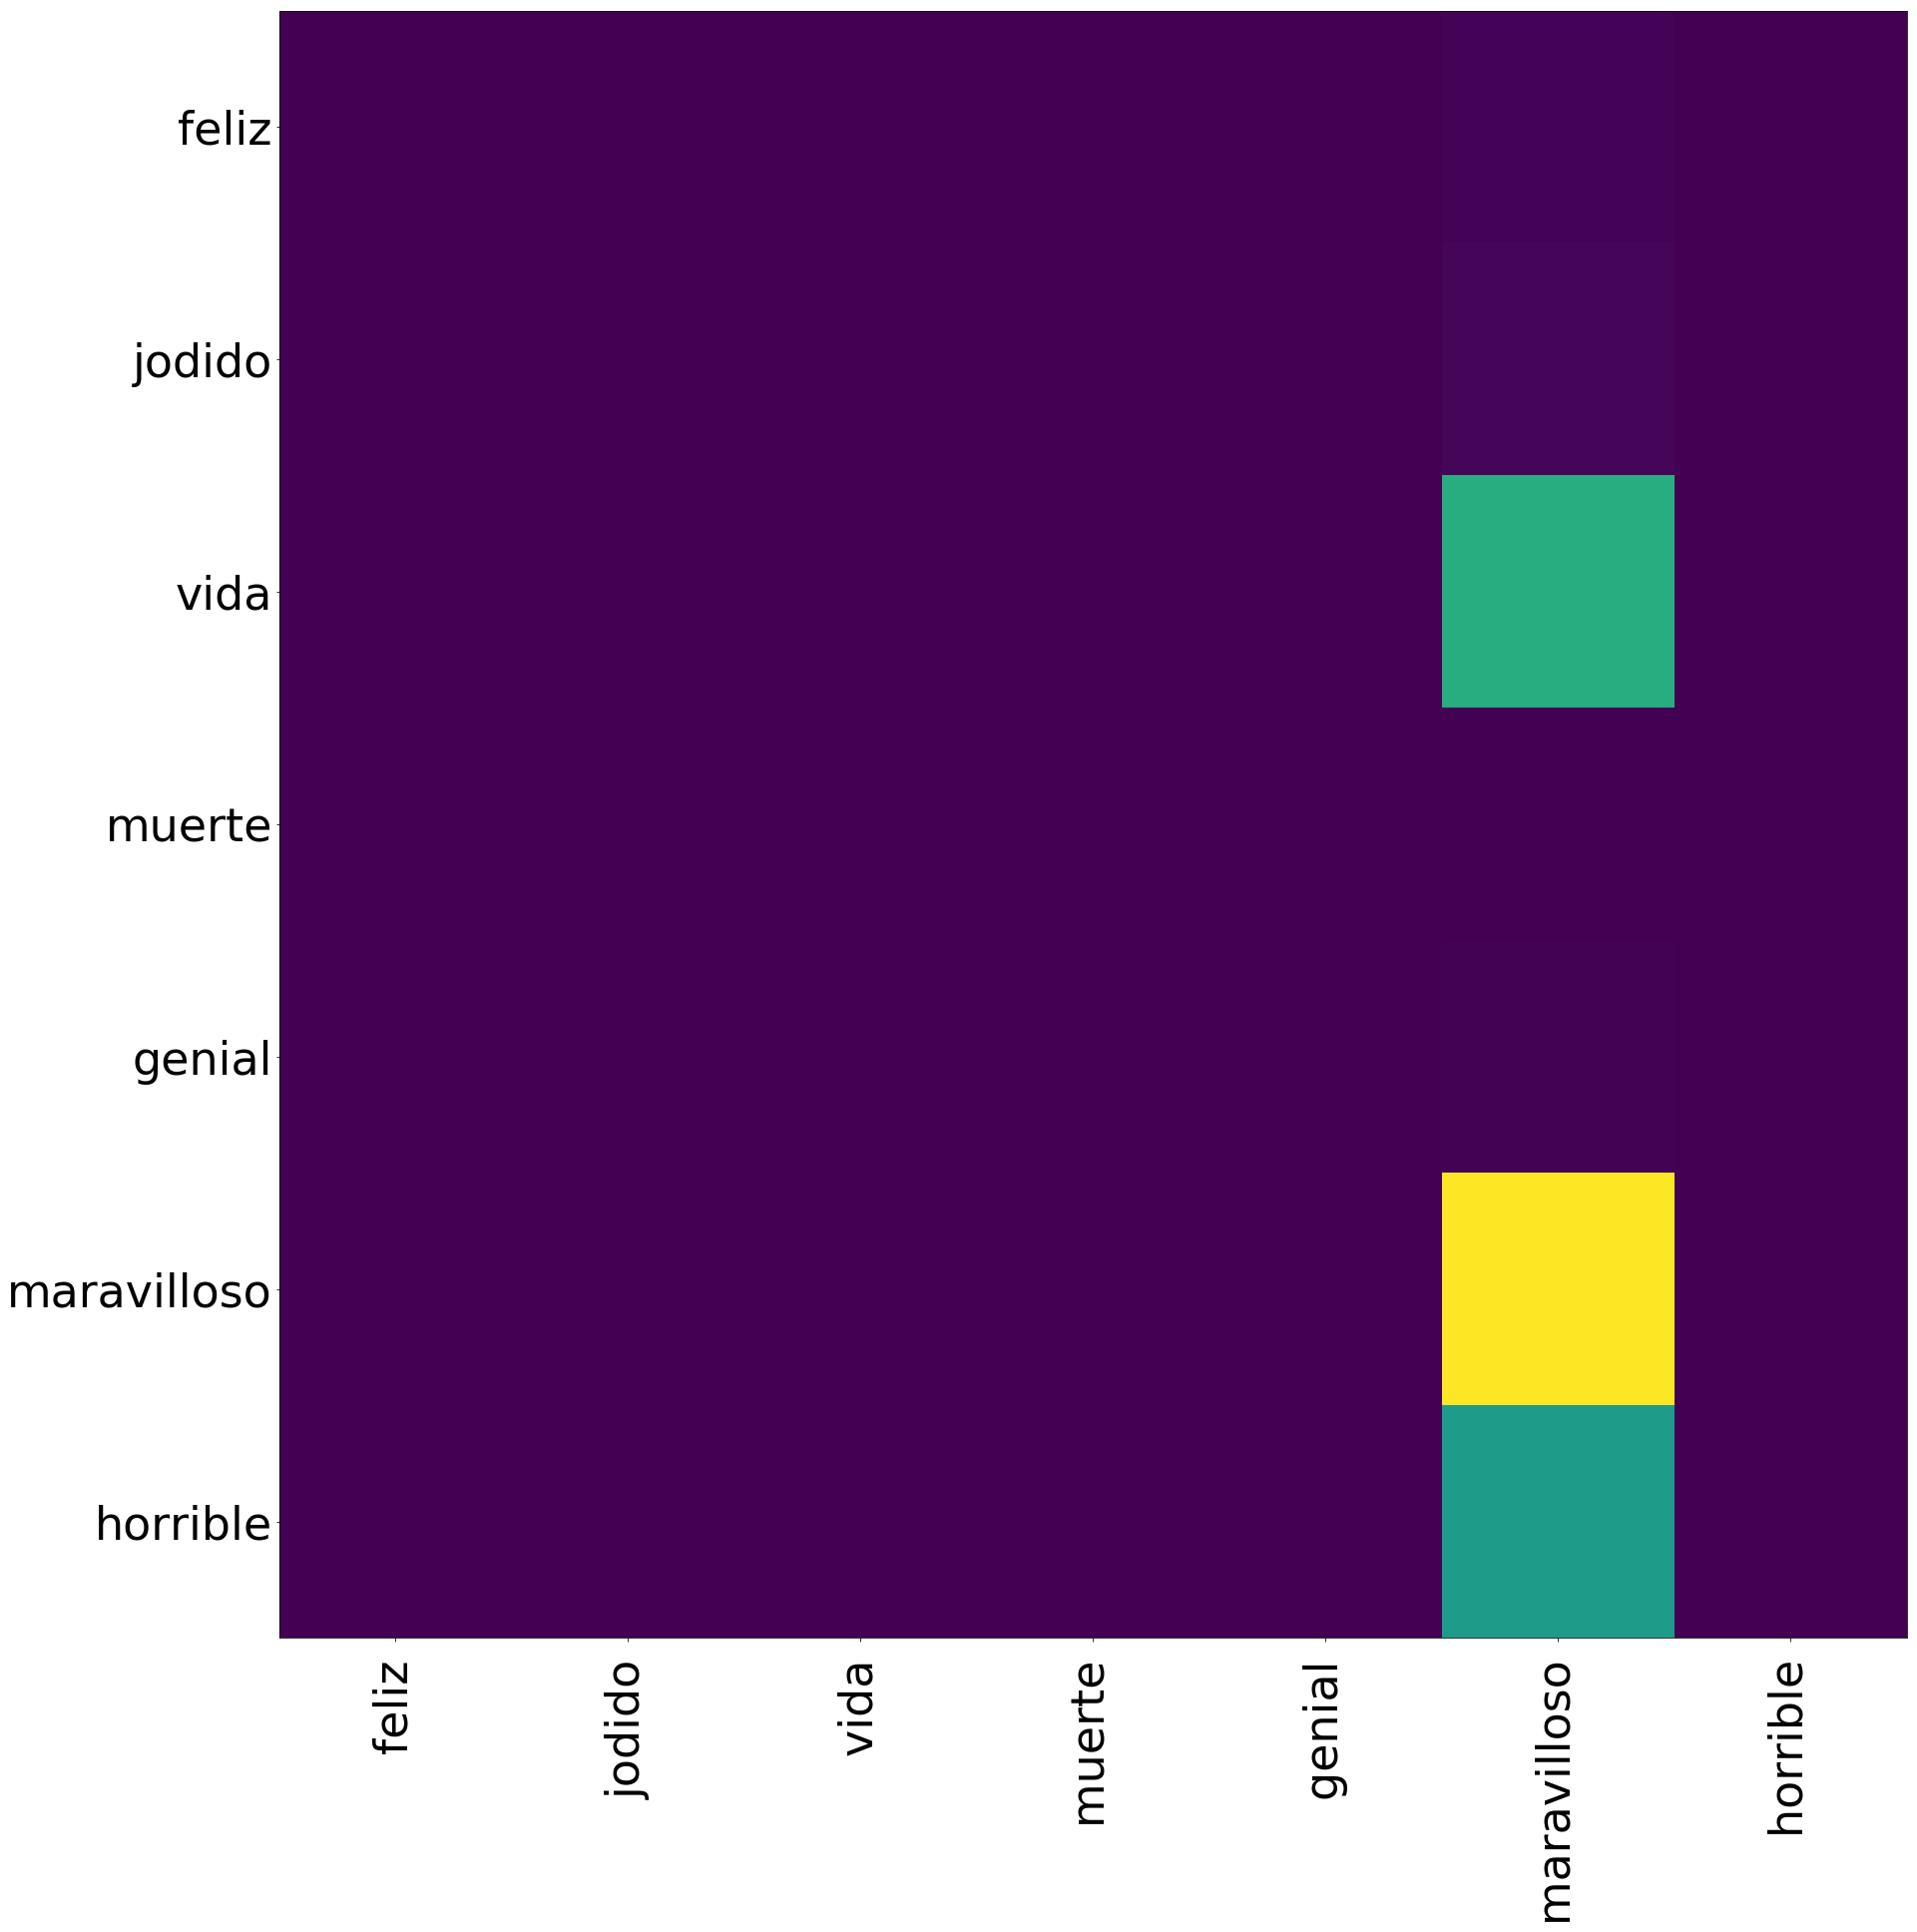

In [53]:
Visualization.visualize_attentions(attns_h_6, 30, 30, rows=1, columns=1, ticks=l_words, output_file=None,
                                   save=False)

In [42]:
a = np.array([[[1, 2, 3], 
               [4, 5, 6], 
               [7, 8, 9]], 
              
              [[1, 2, 3], 
               [4, 5, 6], 
               [7, 8, 9]], 
              
              [[1, 2, 3], 
               [4, 5, 6], 
               [7, 8, 9]],
              
              
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])

In [43]:
a.shape

(9, 3, 3)

In [44]:
a.sum(axis=1)

array([[12, 15, 18],
       [12, 15, 18],
       [12, 15, 18],
       [12, 15, 18],
       [12, 15, 18],
       [12, 15, 18],
       [12, 15, 18],
       [12, 15, 18],
       [12, 15, 18]])